# Import Library

In [1]:
import warnings
warnings.filterwarnings('ignore')

import re
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import time, warnings
import datetime as dt

# Load Dataset

In [2]:
df = pd.read_csv('E:/Retail_Data_Transactions.csv')

# Preprocessing Data

In [3]:
display(df.info())
display(df.isna().sum())
display(df['customer_id'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125000 entries, 0 to 124999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   customer_id  125000 non-null  object
 1   trans_date   125000 non-null  object
 2   tran_amount  125000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.9+ MB


None

customer_id    0
trans_date     0
tran_amount    0
dtype: int64

CS4424    39
CS4320    38
CS3799    36
CS2620    35
CS1215    35
          ..
CS8559     4
CS8376     4
CS7224     4
CS7716     4
CS7333     4
Name: customer_id, Length: 6889, dtype: int64

* Dikarenakan tidak ada missing value, sehingga tidak perlu dilakukan handling missing value.<br>
* Terdapat 6889 customer yang sudah melakukan transaksi.

In [4]:
# removing duplicates
df=df[['customer_id','trans_date', 'tran_amount']].drop_duplicates()

In [5]:
# changing the date according to the date format in python
df['trans_date'] =pd.to_datetime(df.trans_date)
df = df.sort_values(by='trans_date')

In [6]:
# need to filter tran_amount greater than zero.
df = df[(df['tran_amount']>0)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124994 entries, 66979 to 28459
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   customer_id  124994 non-null  object        
 1   trans_date   124994 non-null  datetime64[ns]
 2   tran_amount  124994 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 3.8+ MB


In [7]:
df.describe()

,tran_amount
count,124994.000000
mean,64.992504
std,22.859952
min,10.000000
25%,47.000000
50%,65.000000
75%,83.000000
max,105.000000


Data `tran_amount` cenderung normal karena nilai mean mendekati nilai median.

# EDA

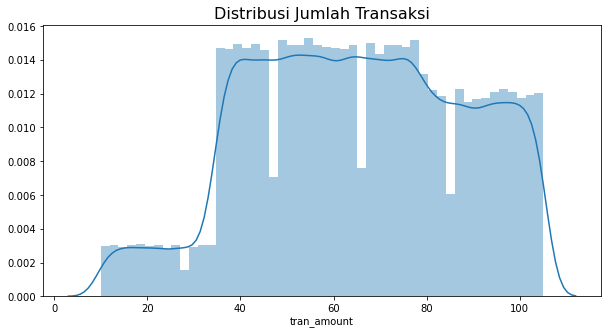

In [8]:
plt.figure(figsize = (10,5))
sns.distplot(df['tran_amount'])
plt.title('Distribusi Jumlah Transaksi', fontsize=16);
plt.show()

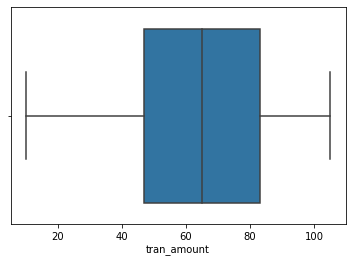

In [9]:
ax = sns.boxplot(x=df['tran_amount'])

Tidak ada outlier pada data jumlah transaksi yaitu `tran_amount`<br>
# Proses data awal yang berupa transaksi menjadi data yang berisi informasi RFM setiap pelanggan
### Recency - Kebaruan: Kapan terakhir kali sang pemegang kartu Matahati berbelanja?

In [10]:
#group by customers and check last date of purshace
recency_df = df.groupby('customer_id').trans_date.max().reset_index()
recency_df.columns = ['CustomerID','LastPurshaceDate']
recency_df.head(10)

,CustomerID,LastPurshaceDate
0,CS1112,2015-01-14
1,CS1113,2015-02-09
2,CS1114,2015-02-12
3,CS1115,2015-03-05
4,CS1116,2014-08-25
5,CS1117,2014-07-02
6,CS1118,2015-03-14
7,CS1119,2015-03-05
8,CS1120,2015-03-06
9,CS1121,2015-02-03


In [11]:
# Compare the last transaction of the dataset with last transaction dates of the individual customer IDs.
recency_df['Recency'] = (recency_df['LastPurshaceDate'].max() - recency_df['LastPurshaceDate']).dt.days
recency_df

,CustomerID,LastPurshaceDate,Recency
0,CS1112,2015-01-14,61
1,CS1113,2015-02-09,35
2,CS1114,2015-02-12,32
3,CS1115,2015-03-05,11
4,CS1116,2014-08-25,203
...,...,...,...
6884,CS8996,2014-12-09,97
6885,CS8997,2014-06-28,261
6886,CS8998,2014-12-22,84
6887,CS8999,2014-07-02,257


### Frequency - Frekuensi: Berapa kali sang pemegang kartu Matahati belanja sebulan terakhir?

In [12]:
#get order counts for each user and create a dataframe with it
frequency_df = df.groupby('customer_id').trans_date.count().reset_index()
frequency_df.columns = ['CustomerID','Frequency']
frequency_df

,CustomerID,Frequency
0,CS1112,15
1,CS1113,20
2,CS1114,19
3,CS1115,22
4,CS1116,13
...,...,...
6884,CS8996,13
6885,CS8997,14
6886,CS8998,13
6887,CS8999,12


### Monetary - Nilai Moneter: Berapa banyak uang yang sudah dihabiskan sang pemegang kartu Matahati?

In [13]:
monetary_df = df.groupby(by='customer_id',as_index=False).agg({'tran_amount': 'sum'})
monetary_df.columns = ['CustomerID','Monetary']
monetary_df.head()

,CustomerID,Monetary
0,CS1112,1012
1,CS1113,1490
2,CS1114,1432
3,CS1115,1659
4,CS1116,857


### Create RFM Table

In [14]:
#merge recency dataframe with frequency dataframe
df1 = recency_df.merge(frequency_df,on='CustomerID')
df1.head()

,CustomerID,LastPurshaceDate,Recency,Frequency
0,CS1112,2015-01-14,61,15
1,CS1113,2015-02-09,35,20
2,CS1114,2015-02-12,32,19
3,CS1115,2015-03-05,11,22
4,CS1116,2014-08-25,203,13


In [15]:
#merge with monetary dataframe to get a table with the 3 columns
rfm = df1.merge(monetary_df,on='CustomerID')
#use CustomerID as index
rfm.set_index('CustomerID',inplace=True)
rfm.drop('LastPurshaceDate', axis=1, inplace=True)
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
CS1112,61,15,1012
CS1113,35,20,1490
CS1114,32,19,1432
CS1115,11,22,1659
CS1116,203,13,857


# Segmentasi data pelanggan dengan RFM Quartiles

Sekarang akan dikelompokkan pelanggan berdasarkan nilai RFM. Karena ini adalah nilai kontinu, kita juga dapat menggunakan nilai kuantil dan membaginya menjadi 4 kelompok.

In [16]:
# create labels and assign them to tree percentile groups 
r_labels = range(4, 0, -1)
r_groups = pd.qcut(rfm.Recency, q = 4, labels = r_labels)
f_labels = range(1, 5)
f_groups = pd.qcut(rfm.Frequency, q = 4, labels = f_labels)
m_labels = range(1, 5)
m_groups = pd.qcut(rfm.Monetary, q = 4, labels = m_labels)

Harap berikan perhatian ekstra untuk `r_labels`. Saya memberi label dalam urutan menurun. Mengapa demikian? Karena Recency berarti berapa lama waktu yang telah berlalu sejak pesanan terakhir pelanggan. Oleh karena itu, semakin kecil nilainya, semakin terlibat pelanggan dengan merek tersebut. Sekarang mari kita buat kolom baru untuk menunjukkan label grup.

In [17]:
# make a new column for group labels
rfm['R'] = r_groups.values
rfm['F'] = f_groups.values
rfm['M'] = m_groups.values
# sum up the three columns
rfm['RFM_Segment'] = rfm.apply(lambda x: str(x['R']) + str(x['F']) + str(x['M']), axis = 1)
rfm['RFM_Score'] = rfm[['R', 'F', 'M']].sum(axis = 1)
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
CS1112,61,15,1012,2,2,2,222,6.0
CS1113,35,20,1490,3,3,3,333,9.0
CS1114,32,19,1432,3,3,3,333,9.0
CS1115,11,22,1659,4,3,4,434,11.0
CS1116,203,13,857,1,1,2,112,4.0


Saya melampirkan ketiga label dalam satu sel sebagai RFM_Segment. Dengan cara ini, kita dapat dengan mudah memeriksa level atau segmen mana yang dimiliki pelanggan. `RFM_Score` adalah jumlah total dari ketiga nilai. Tidak harus berupa penjumlahan sehingga nilai rata-rata juga dimungkinkan. Selain itu, kita dapat menangkap pola lebih lanjut dengan nilai mean atau nilai hitung dari Recency, Frequency, Monetary yang dikelompokkan berdasarkan skor ini seperti di bawah ini:

In [18]:
# calculate averae values for each RFM
rfm_agg = rfm.groupby('RFM_Score').agg({
    'Recency' : 'mean',
    'Frequency' : 'mean',
    'Monetary' : ['mean', 'count']
})
rfm_agg.round(1).head()

Recency Frequency Monetary      
             mean      mean     mean count
RFM_Score                                 
3.0         235.1      10.7    501.3   550
4.0         130.4      12.7    649.3   548
5.0         108.2      14.1    818.9   737
6.0          68.8      15.0    892.5   824
7.0          80.3      17.5   1136.0   851

RFM_Score akan menjadi skor total dari keterlibatan atau loyalitas pelanggan. Dengan merangkum ketiga nilai tersebut, kami akhirnya dapat mengkategorikan pelanggan menjadi `Green`, `Bronze`, `Silver`, `Gold`.

In [19]:
# assign labels from total score
score_labels = ['Green', 'Bronze', 'Silver', 'Gold']
score_groups = pd.qcut(rfm.RFM_Score, q = 4, labels = score_labels)
rfm['RFM_Level'] = score_groups.values
rfm

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level
CustomerID,,,,,,,,,
CS1112,61,15,1012,2,2,2,222,6.0,Bronze
CS1113,35,20,1490,3,3,3,333,9.0,Silver
CS1114,32,19,1432,3,3,3,333,9.0,Silver
CS1115,11,22,1659,4,3,4,434,11.0,Gold
CS1116,203,13,857,1,1,2,112,4.0,Green
...,...,...,...,...,...,...,...,...,...
CS8996,97,13,582,2,1,1,211,4.0,Green
CS8997,261,14,543,1,1,1,111,3.0,Green
CS8998,84,13,624,2,1,1,211,4.0,Green


Berdasarkan hasil `RFM Level` dapat diketahui bahwa customer yang termasuk level `Gold` memiliki RFM Score yang paling tinggi dibandingkan pelanggan lain, sedangkan level `Green` memiliki RFM score paling rendah yaitu antara 3-4. Pelanggan dengan kategori `Gold` merupakan pelanggan yang sangat loyal/setia, sedangkan `Green` perlu berhati-hati dengan pelanggan tersebut.<br>
Pengelompokkan tersebut sangat berguna untuk menargetkan atau menangani setiap segmen.<br>
Sebagai contoh:<br>
`Gold - Juara`: Hadiahi mereka. Mereka dapat menjadi pengguna awal produk baru. Sarankan mereka "Referensikan teman".<br>
`Green`: Kirimi mereka email yang dipersonalisasi untuk mendorong mereka berbelanja.<br>

# Segmentasi data pelanggan dengan K-Means Clustering

Dalam hal pengelompokan K-means, penskalaan dan normalisasi data merupakan langkah penting untuk preprocessing. Hasil distribusi nilai RFM, dapat dilihat bahwa nilai tersebut miring ke kiri. Ini bukan kondisi yang baik untuk digunakan tanpa standardisasi. Mari kita ubah nilai RFM menjadi skala log terlebih dahulu dan kemudian menormalkannya.

In [20]:
# define function for the values below 0
def neg_to_zero(x):
    if x <= 0:
        return 1
    else:
        return x
# apply the function to Recency and MonetaryValue column 
rfm['Recency'] = [neg_to_zero(x) for x in rfm.Recency]
rfm['Monetary'] = [neg_to_zero(x) for x in rfm.Monetary]
# unskew the data
rfm_log = rfm[['Recency', 'Frequency', 'Monetary']].apply(np.log, axis = 1).round(3)

Dan kemudian, transformasi log diterapkan untuk setiap nilai RFM. Langkah prapemrosesan berikutnya adalah penskalaan menggunakan StandardScaler(), kita bisa mendapatkan nilai standar seperti di bawah ini.

In [21]:
# To Scale our data
from sklearn.preprocessing import StandardScaler

# To perform KMeans clustering 
from sklearn.cluster import KMeans
# scale the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)
# transform into a dataframe
rfm_scaled = pd.DataFrame(rfm_scaled, index = rfm.index, columns = rfm_log.columns)

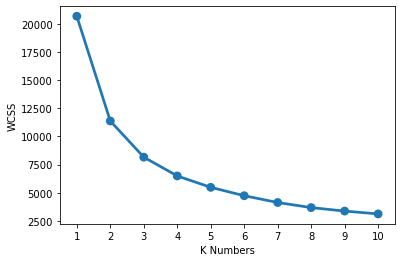

In [22]:
# the Elbow method
wcss = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters= k, init= 'k-means++', max_iter= 300)
    kmeans.fit(rfm_scaled)
    wcss[k] = kmeans.inertia_
# plot the WCSS values
sns.pointplot(x = list(wcss.keys()), y = list(wcss.values()))
plt.xlabel('K Numbers')
plt.ylabel('WCSS')
plt.show()

Berdasarkan hasil metode `Elbow` diperoleh jumlah cluster optimal adalah 4 cluster.

In [23]:
# clustering
clus = KMeans(n_clusters= 4, init= 'k-means++', max_iter= 300)
clus.fit(rfm_scaled)
# Assign the clusters to datamart
rfm['K_Cluster'] = clus.labels_
rfm

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level,K_Cluster
CustomerID,,,,,,,,,,
CS1112,61,15,1012,2,2,2,222,6.0,Bronze,2
CS1113,35,20,1490,3,3,3,333,9.0,Silver,1
CS1114,32,19,1432,3,3,3,333,9.0,Silver,1
CS1115,11,22,1659,4,3,4,434,11.0,Gold,3
CS1116,203,13,857,1,1,2,112,4.0,Green,2
...,...,...,...,...,...,...,...,...,...,...
CS8996,97,13,582,2,1,1,211,4.0,Green,0
CS8997,261,14,543,1,1,1,111,3.0,Green,0
CS8998,84,13,624,2,1,1,211,4.0,Green,0


# Interpretasi segmentasi pelanggan

Berdasarkan hasil `RFM Level` dapat diketahui bahwa customer yang termasuk level `Gold` memiliki RFM Score yang paling tinggi dibandingkan pelanggan lain, sedangkan level `Green` memiliki RFM score paling rendah yaitu antara 3-4. Pelanggan dengan kategori `Gold` merupakan pelanggan yang sangat loyal/setia, sedangkan `Green` perlu berhati-hati dengan pelanggan tersebut.<br>
Pengelompokkan tersebut sangat berguna untuk menargetkan atau menangani setiap segmen.<br>
Sebagai contoh:<br>
`Gold - Juara`: Hadiahi mereka. Mereka dapat menjadi pengguna awal produk baru. Sarankan mereka "Referensikan teman".<br>
`Green`: Kirimi mereka email yang dipersonalisasi untuk mendorong mereka berbelanja.<br>

# Snake plot and heatmap

Saya akan membuat dua jenis plot, line plot dan heatmap. Kita dapat dengan mudah membandingkan perbedaan nilai RFM dengan kedua plot ini. Pertama, saya akan membuat kolom untuk menetapkan dua label pengelompokan. Dan kemudian membentuk kembali data frame dengan menggabungkan nilai RFM menjadi satu kolom.

In [24]:
# assign cluster column 
rfm_scaled['K_Cluster'] = clus.labels_
rfm_scaled['RFM_Level'] = rfm.RFM_Level
rfm_scaled.reset_index(inplace = True)
# melt the dataframe
rfm_melted = pd.melt(frame= rfm_scaled, id_vars= ['CustomerID', 'RFM_Level', 'K_Cluster'], var_name = 'Metrics', value_name = 'Value')
rfm_melted.head()

,CustomerID,RFM_Level,K_Cluster,Metrics,Value
0,CS1112,Bronze,2,Recency,0.258259
1,CS1113,Silver,1,Recency,-0.171021
2,CS1114,Silver,1,Recency,-0.239737
3,CS1115,Gold,3,Recency,-1.064327
4,CS1116,Green,2,Recency,1.186309


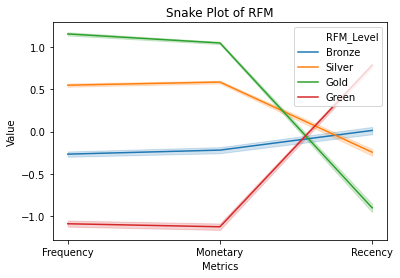

In [25]:
# a snake plot with RFM
sns.lineplot(x = 'Metrics', y = 'Value', hue = 'RFM_Level', data = rfm_melted)
plt.title('Snake Plot of RFM')
plt.legend(loc = 'upper right');

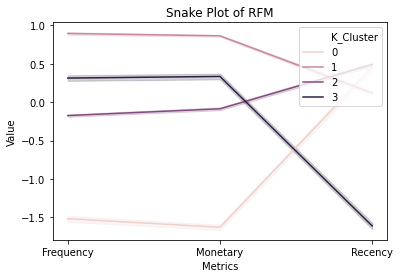

In [26]:
# a snake plot with K-Means
sns.lineplot(x = 'Metrics', y = 'Value', hue = 'K_Cluster', data = rfm_melted)
plt.title('Snake Plot of RFM')
plt.legend(loc = 'upper right')

Jenis plot ini disebut `Snake plot` terutama dalam analisis pemasaran. Tampaknya kelompok `Gold`, `Silver`, `Bronze`, dan `Green` di plot RFM Quartile berturut-turut mirip dengan cluster `3`, `1`,`2`, dan `0` di RFM dengan K-means clustering.<br>